# Short introduction to Rudof

This document contains a short introduction to [rudof](https://rudof-project.github.io/), an RDF data shapes library.

Rudof is available as a [command line tool](https://rudof-project.github.io/rudof/overview.html) for which we provide [binaries in Windows, Linux and Mac](https://github.com/rudof-project/rudof/releases).

The library also contains Python bindings which are [publised in pypi](https://pypi.org/project/pyrudof/).

The documentation for the Python bindings is available [here](https://pyrudof.readthedocs.io/en/latest/).

This document can also be seen as a short demo of those bindings.

## Install and initialize rudof

The library is available as `pyrudof`.

In [1]:
!pip install pyrudof

The main entry point if a class called `Rudof` through which most of the functionality is provided.

In [2]:
from pyrudof import Rudof, RudofConfig

In order to initialize that class, it is possible to pass a RudofConfig instance which contains configuration parameters for customization.

In [3]:
rudof = Rudof(RudofConfig())

## Handling RDF data

In [4]:
rudof.read_data_str("""
prefix : <http://example.org/>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>

:x a :Person     ;
   :name "Alice" ;
   :knows :y     .
:y a :Person     ;
   :name "Bob"   ;
   :knows :z     .
:z a :Person     ;
   :knows :x     .
""")

The RDF data can easily be merged with other data.

In [5]:
rudof.read_data_str("""
prefix : <http://example.org/>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>

:u a :Person     ;
   :name "Dave" ;
   :knows :y     .
:v a :Person     ;
   :name "Emily" ;
   :knows _:1    .
_:1 a :Person     ;
   :knows :x     .
""")

And the data can be serialized to different formats.

In [6]:
from pyrudof import RDFFormat
str = rudof.serialize_data(format=RDFFormat.NTriples)
print(str)

<http://example.org/v> <http://example.org/name> "Emily" .
<http://example.org/v> <http://example.org/knows> _:1 .
<http://example.org/v> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Person> .
<http://example.org/z> <http://example.org/knows> <http://example.org/x> .
<http://example.org/z> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Person> .
<http://example.org/u> <http://example.org/name> "Dave" .
<http://example.org/u> <http://example.org/knows> <http://example.org/y> .
<http://example.org/u> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Person> .
<http://example.org/y> <http://example.org/name> "Bob" .
<http://example.org/y> <http://example.org/knows> <http://example.org/z> .
<http://example.org/y> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Person> .
<http://example.org/x> <http://example.org/name> "Alice" .
<http://example.org/x> <http://example.org/knows> <http://example.org/y> .

## Running SPARQL queries

In [7]:
from pyrudof import Rudof, RudofConfig, QuerySolutions
rudof = Rudof(RudofConfig())
rudof.reset_all()

In [8]:
rdf = """prefix : <http://example.org/>
:alice a :Person ;
 :name "Alice"   ;
 :knows :bob     .
:bob a :Person   ;
 :name "Robert"  .
"""
rudof.read_data_str(rdf)

In [9]:
query = """prefix : <http://example.org/>
select * where {
  ?x a :Person
}
"""

results = rudof.run_query_str(query)


Show the results:

In [10]:
for result in iter(results):
    print(result.show())

?x -> <http://example.org/bob>

?x -> <http://example.org/alice>



## Validate using SHACL

In [11]:
# @title
rudof.reset_all()

Let's read some RDF data.

In [12]:
rudof.read_data_str("""
prefix : <http://example.org/>
prefix sh:     <http://www.w3.org/ns/shacl#>
prefix xsd:    <http://www.w3.org/2001/XMLSchema#>

:Person a sh:NodeShape;
   sh:targetNode :ok, :ko ;
   sh:property [
    sh:path     :name ;
    sh:minCount 1;
    sh:maxCount 1;
    sh:datatype xsd:string ;
  ] .
""")

In [13]:
rudof.read_data_str("""
prefix : <http://example.org/>

:ok :name "alice" .
:ko :name 1 .
""")

In [14]:
result = rudof.validate_shacl()

In [15]:
print(result.show())

1 errors found
sh:Violation node: :ko sh:datatype
Datatype constraint not satisfied. Expected datatype: http://www.w3.org/2001/XMLSchema#string:name,_:ff6f9dda59628b26f5cfe91db94f935b1



The next command is just to clean the RDF data for the next examples.

In [16]:
rudof.reset_all()

## Validate using ShEx

In [17]:
rudof.read_shex_str("""
prefix : <http://example.org/>
prefix xsd:    <http://www.w3.org/2001/XMLSchema#>

:Person {
 :name xsd:string
}
""")


In [18]:
rudof.read_data_str("""
prefix : <http://example.org/>

:ok :name "alice" .
:ko :name 1 .
""")

In [19]:
rudof.read_shapemap_str(":ok@:Person, :ko@:Person")

Once the ShEx schema and the Shapemap have been added to `rudof`, it is possible to validate the current RDF data with the `validate_shex()` method:

In [20]:
results = rudof.validate_shex()

`validate_shex()` returns a `ResultShapeMap` object which contains a `show()` method to show the results of the validation:

In [21]:
for (node, shape, status) in results.to_list():
    print(f"Node: {node.show()}")
    print(f"Shape: {shape.show()}")
    print(f"Conformant?: {status.is_conformant()}")
    print(f"Appinfo: {status.as_json()}")
    print("")


Node: http://example.org/ok
Shape: http://example.org/Person
Conformant?: True
Appinfo: {'info': [{'reason': 'Shape passed. Node http://example.org/ok, shape 0: Shape  Preds: http://example.org/name, TripleExpr: RBE [C0], Keys: [http://example.org/name -> {C0}], conds: [C0 -> xsd:string], References: []'}], 'reason': 'Shape passed. Node :ok, shape 0: :Person = {:name xsd:string}\n', 'status': 'conformant'}

Node: http://example.org/ko
Shape: http://example.org/Person
Conformant?: False
Appinfo: {'info': [{'error': 'Datatype error: Datatype expected http://www.w3.org/2001/XMLSchema#string but found http://www.w3.org/2001/XMLSchema#integer for literal with lexical form 1'}], 'reason': 'Error Datatype error: Datatype expected http://www.w3.org/2001/XMLSchema#string but found http://www.w3.org/2001/XMLSchema#integer for literal with lexical form 1\n', 'status': 'nonconformant'}



We reset the status of the `ShEx` schema, the `Shapemap` and the current `RDF data` for the next section.

In [22]:
rudof.reset_all()

## Converting ShEx to UML

`rudof` can be used to convert ShEx to diagrams in UML-like style. The converter generates a [PlantUML](https://plantuml.com/) string which can be written to a file and converted to an image using the PlantUML tool.

In [23]:
from pyrudof import UmlGenerationMode

In [24]:
rudof.read_shex_str("""
prefix : <http://example.org/>
prefix xsd:    <http://www.w3.org/2001/XMLSchema#>

:User {
 :name     xsd:string  ;
 :worksFor @:Company * ;
 :addres   @:Address   ;
 :knows    @:User
}

:Company {
  :name     xsd:string     ;
  :code     xsd:string     ;
  :employee @:User
}
:Address {
  :name     xsd:string ;
  :zip_code xsd:string
}
""")

In [25]:
plant_uml = rudof.shex2plantuml_file(UmlGenerationMode(), 'out.puml')

Now we install the PlantUML tools necessary to process the generated `plant_uml`

In [26]:
! pip install plantuml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/91.1 kB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/113.9 kB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 9.8 MB/s eta 0:00:00


In [27]:
! pip install ipython

In [28]:
!python -m plantuml out.puml

[{'filename': 'out.puml', 'gen_success': True}]


In [29]:
from IPython.display import Image

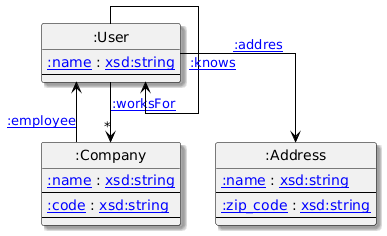

In [30]:
Image(f"out.png")

In [31]:
rudof.reset_all()

## Converting DCTAP to ShEx

Rudof can be used to convert [DCTAP](https://www.dublincore.org/specifications/dctap/) files to ShEx.

DCTAP can be used to represent shapes using a tabular representation using CSV or an spreadsheet format like XLSX. As an example, the following CSV data:


In [32]:
dctap_str = """shapeId,propertyId,Mandatory,Repeatable,valueDatatype,valueShape
Person,name,true,false,xsd:string,
,birthdate,false,false,xsd:date,
,worksFor,false,true,,Company
Company,name,true,false,xsd:string,
,employee,false,true,,Person
"""

In [33]:
rudof.read_dctap_str(dctap_str)

In [34]:
dctap = rudof.get_dctap()

In [35]:
print(dctap)

Shape(Person)  
 name xsd:string 
 birthdate xsd:date ?
 worksFor @Company *
Shape(Company)  
 name xsd:string 
 employee @Person *



It is possible to convert the DCTAP obtained to ShEx

In [36]:
rudof.dctap2shex()


In [37]:
from pyrudof import ShExFormatter

In [38]:
shex = rudof.get_shex()

result = rudof.serialize_shex(shex, ShExFormatter())


In [39]:
print(result)

prefix dc: <http://purl.org/dc/elements/1.1/>
prefix : <http://example.org/>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix sh: <http://www.w3.org/ns/shacl#>
:Person {
    :name xsd:string;
    :birthdate xsd:date ?;
    :worksFor @:Company *
}
:Company {
    :name xsd:string;
    :employee @:Person *
}


## Support for RDF 1.2

Reset previous state of `rudof` and remnove the temporary file `out.puml` if it exists.

In [40]:
rudof.reset_all()

In [41]:
!rm -f out.puml out.png

Rudof has added support for [RDF 1.2](https://www.w3.org/TR/rdf12-primer). It is possible, for example, to load some RDF 1.2 files and visualize them.


RDF 1.2 introduces [triple terms](https://www.w3.org/TR/rdf12-primer/#section-triple-terms) which denote statements that can be the object of some triples.

For example, we can state that `:bob` is interested in `:MonaLisa` since `4th October 1998` using the following code:

In [42]:
rudof.read_data_str("""
 prefix : <http://example.org/>
 prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
 prefix xsd: <http://www.w3.org/2001/XMLSchema#>

 :aliceBelief a :Statement ;
    rdf:reifies <<( :bob :knows :dave  )>> ;
    :since 2025 ;
    :accordingTo :dave  .
 """)


In [43]:
uml = rudof.data2plantuml_file('out.puml')

Visual graph: VisualRDFGraph with 11 nodes and 4 edges
Node 3: Predicate: rdf:type (<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>)
     count: UsageCount { as_predicate: 1, as_subject: 0, as_object: 0, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 8: NonAssertedTriple
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 1, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 0: Iri: :aliceBelief (http://example.org/aliceBelief)
     count: UsageCount { as_predicate: 0, as_subject: 4, as_object: 0, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 2: Iri: :dave (http://example.org/dave)
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 1, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 1 }
Node 10: Literal: 2025
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 1, as_predicate_in_triple: 0, as_subject_in_triple: 

Convert the `puml` to an image.

In [44]:
!python -m plantuml out.puml

[{'filename': 'out.puml', 'gen_success': True}]


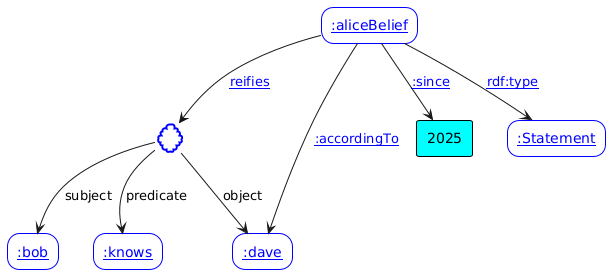

In [45]:
Image(f"out.png")

In [RDF 1.2 turtle syntax](https://www.w3.org/TR/rdf12-turtle/), there are several possibilities to define triple terms.



### Declaring triple terms directly

In [46]:
!rm -f out.puml out.pnf
rudof.reset_all()

A triple term can be declared enclosing it between `<<(` and `)>>`. For example:

In [47]:
rudof.read_data_str("""
PREFIX :    <http://www.example.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

_:e38  :familyName                     "Smith" .
_:anno rdf:reifies <<( _:e38 :jobTitle "Designer" )>> .
_:anno :accordingTo                     :eric .
 """)

In [48]:
uml = rudof.data2plantuml_file('out.puml')

Visual graph: VisualRDFGraph with 10 nodes and 3 edges
Node 0: BlankNode: e38
     count: UsageCount { as_predicate: 0, as_subject: 1, as_object: 0, as_predicate_in_triple: 0, as_subject_in_triple: 1, as_object_in_triple: 0 }
Node 5: Iri: :eric (http://www.example.org/eric)
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 1, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 7: Predicate: :jobTitle (<http://www.example.org/jobTitle>)
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 0, as_predicate_in_triple: 1, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 4: Predicate: :accordingTo (<http://www.example.org/accordingTo>)
     count: UsageCount { as_predicate: 1, as_subject: 0, as_object: 0, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 8: Literal: "Designer"
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 0, as_predicate_in_triple: 0, as_subject_in_tripl

In [49]:
!python -m plantuml out.puml

[{'filename': 'out.puml', 'gen_success': True}]


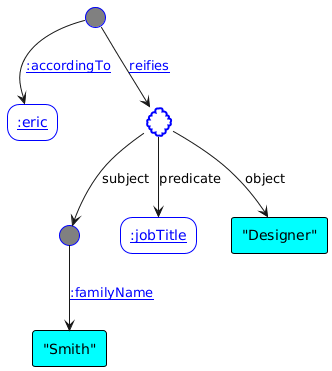

In [50]:
Image(f"out.png")

### Reifying triples

In [51]:
!rm -f out.puml out.pnf
rudof.reset_all()

Enclosing a triple between `<<` and `>>`, is a syntactic sugar that declares that there is a reifier whose object is that triple and that can be used to add more declarations about that reifier.

For example:

In [52]:
rudof.read_data_str("""
 PREFIX :    <http://www.example.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

:employee38 :familyName "Smith" .
<< :employee38 :jobTitle "Assistant Designer" >> :accordingTo :employee22 .
 """)

Visual graph: VisualRDFGraph with 10 nodes and 3 edges
Node 5: Iri: :employee22 (http://www.example.org/employee22)
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 1, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 2: Literal: "Smith"
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 1, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 1: Predicate: :familyName (<http://www.example.org/familyName>)
     count: UsageCount { as_predicate: 1, as_subject: 0, as_object: 0, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 0: Iri: :employee38 (http://www.example.org/employee38)
     count: UsageCount { as_predicate: 0, as_subject: 1, as_object: 0, as_predicate_in_triple: 0, as_subject_in_triple: 1, as_object_in_triple: 0 }
Node 3: BlankNode: d8df43bd75deed1f426f7761b98bd246
     count: UsageCount { as_predicate: 0, as_subject: 2, as_object: 0, as_predicate_i

[{'filename': 'out.puml', 'gen_success': True}]


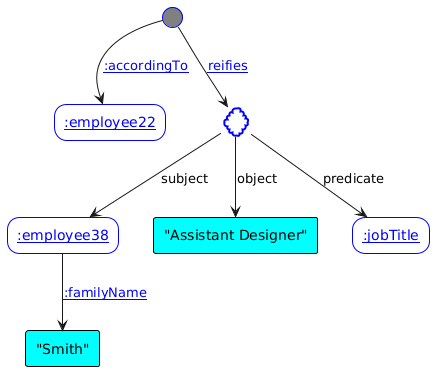

In [53]:
uml = rudof.data2plantuml_file('out.puml')
!python -m plantuml out.puml
Image(f"out.png")

### Annotation syntax

In [54]:
# Clean the workspace
!rm -f out.puml out.pnf
rudof.reset_all()

It is also possible to use the annotation syntax where a statement can be annotated with `{|` and `|}` as follows:


In [55]:
rudof.read_data_str("""
 PREFIX : <http://example.com/>
 PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
 :alice :name "Alice" ~ :t {|
   :statedBy :bob ;
   :recorded "2021-07-07"^^xsd:date
 |} .
 """)

Visual graph: VisualRDFGraph with 10 nodes and 4 edges
Node 0: Iri: :alice (http://example.com/alice)
     count: UsageCount { as_predicate: 0, as_subject: 1, as_object: 0, as_predicate_in_triple: 0, as_subject_in_triple: 1, as_object_in_triple: 0 }
Node 2: Literal: "Alice"
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 1, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 1 }
Node 5: Literal: "2021-07-07"^^xsd:date
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 1, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 9: Iri: :bob (http://example.com/bob)
     count: UsageCount { as_predicate: 0, as_subject: 0, as_object: 1, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 6: Reifies
     count: UsageCount { as_predicate: 1, as_subject: 0, as_object: 0, as_predicate_in_triple: 0, as_subject_in_triple: 0, as_object_in_triple: 0 }
Node 8: Predicate: :statedBy (<htt

[{'filename': 'out.puml', 'gen_success': True}]


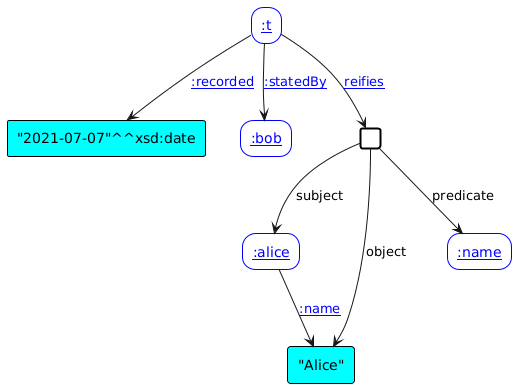

In [56]:
uml = rudof.data2plantuml_file('out.puml')
!python -m plantuml out.puml
Image(f"out.png")

Notice that in the visualization, we differentiate between a statement that is part of the graph which is represented by a box from a statement that is not part of the graph, which is represented by a cloud symbol.

## Comparing Schemas

It is possible to use rudof to compare different schemas. For example:

In [57]:
schema1 = """
 PREFIX : <http://example.org/>
 PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
 :Person {
    :name xsd:string ;
    :age xsd:integer ;
    :weight xsd:float ;
    :worksFor .
 }
""";

In [58]:
schema2 = """
 PREFIX ex: <http://example.org/>
 PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
 ex:Person {
    ex:name xsd:string ;
    ex:birthDate xsd:date ;
    ex:worksFor .
}
"""

In [59]:
result = rudof.compare_schemas_str(
    schema1, schema2,
    "shex", "shex",
    "shexc", "shexc",
    None, None,
    "http://example.org/Person", "http://example.org/Person"
    )

In [60]:
print(f"Result of comparison:\n{result.as_json()}")

Result of comparison:
{
  "equal_properties": {
    "http://example.org/name": {
      "description1": {
        "iri_ref": "http://example.org/name",
        "value_constraint": {
          "Datatype": "http://www.w3.org/2001/XMLSchema#string"
        }
      },
      "description2": {
        "iri_ref": "http://example.org/name",
        "value_constraint": {
          "Datatype": "http://www.w3.org/2001/XMLSchema#string"
        }
      }
    },
    "http://example.org/worksFor": {
      "description1": {
        "iri_ref": "http://example.org/worksFor"
      },
      "description2": {
        "iri_ref": "http://example.org/worksFor"
      }
    }
  },
  "properties1": {
    "http://example.org/age": {
      "description": {
        "iri_ref": "http://example.org/age",
        "value_constraint": {
          "Datatype": "http://www.w3.org/2001/XMLSchema#integer"
        }
      }
    },
    "http://example.org/weight": {
      "description": {
        "iri_ref": "http://example.org/

## Obtaining information about SPARQL endpoints

### When the SPARQL endpoint directly generates the service description in RDF (Uniprot)

It is possible to get information from SPARQL endpoints that publish [service descriptions](https://www.w3.org/TR/sparql11-service-description/) using the [VoID](https://www.w3.org/TR/void/) vocabulary.

In [61]:
# @title

rudof.reset_all()
from pyrudof import ReaderMode, ServiceDescriptionFormat, QueryResultFormat

In [62]:
service = "https://sparql.uniprot.org/sparql"

rudof.read_service_description(service, RDFFormat.Turtle, None, ReaderMode.Strict)


Now we can serialize the service description in JSON, for example, as:

In [63]:
service = rudof.get_service_description()
service_str = service.serialize(ServiceDescriptionFormat.Json)
print(f"Service description in JSON:\n{service_str}")


Service description in JSON:
{
  "title": "UniProt",
  "endpoint": "https://sparql.uniprot.org/sparql",
  "default_dataset": {
    "id": {
      "Iri": "https://sparql.uniprot.org/sparql#sparql-default-dataset"
    },
    "default_graph": {
      "id": {
        "Iri": "https://sparql.uniprot.org/.well-known/void#sparql-default-graph"
      },
      "triples": 239686443056
    },
    "named_graphs": [
      {
        "id": {
          "Iri": "http://sparql.uniprot.org/go"
        },
        "name": "http://sparql.uniprot.org/go",
        "graphs": [
          {
            "id": {
              "Iri": "https://sparql.uniprot.org/.well-known/void#_graph_go!6a4e0939"
            },
            "triples": 694229,
            "classes": 3,
            "property_partition": [
              {
                "id": {
                  "Iri": "https://sparql.uniprot.org/.well-known/void#go!5052af0b!hasRelatedSynonym"
                },
                "property": "http://www.geneontology.org/f

We also support the conversion from service descriptions to MIE format files:

In [64]:
mie = service.as_mie()
print(f"Service description in MIE format as YAML:\n{mie.as_yaml()}")

Service description in MIE format as YAML:
---
schema_info:
  title: UniProt
  endpoint: "https://sparql.uniprot.org/sparql"
prefixes:
  xsd: "http://www.w3.org/2001/XMLSchema#"
  "": "http://www.w3.org/ns/sparql-service-description#"
  dcterms: "http://purl.org/dc/terms/"
  rdf: "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
  void: "http://rdfs.org/ns/void#"
  pav: "http://purl.org/pav/"
  void_ext: "http://ldf.fi/void-ext#"
  formats: "http://www.w3.org/ns/formats/"


### Using SPARQL CONSTRUCT queries

Some endpoints, like RDFPortal, have their service description located as a named graph which can be queried using a SPARQL CONSTRUCT query. In the case of RDFPortal, the service description is located in the graph [endpoint = "https://plod.dbcls.jp/repositories/RDFPortal_VoID"
](endpoint = "https://plod.dbcls.jp/repositories/RDFPortal_VoID"
).

In [65]:
endpoint = "https://plod.dbcls.jp/repositories/RDFPortal_VoID"


In [66]:
construct_query = """
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX sd: <http://www.w3.org/ns/sparql-service-description#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

CONSTRUCT WHERE {
  [
    a sd:Service ;
    sd:defaultDataset [
       a sd:Dataset ;
       sd:namedGraph [
         sd:name <http://sparql.uniprot.org/uniprot> ;
         a sd:NamedGraph ;
         sd:endpoint ?ep_url ;
         sd:graph [
           a void:Dataset ;
           void:triples ?total_count ;
           void:classes ?class_count ;
           void:properties ?property_count ;
           void:distinctObjects ?uniq_object_count ;
           void:distinctSubjects ?uniq_subject_count ;
           void:classPartition [
             void:class ?class_name ;
             void:entities ?class_triple_count
           ] ;
           void:propertyPartition [
             void:property ?property_name ;
             void:triples ?property_triple_count
           ]
         ]
       ]
     ]
  ] .
}
"""

It is possible to run SPARQL CONSTRUCT queries in rudof using:

In [67]:
rudof.add_endpoint(endpoint)

In [68]:
dbcls_turtle = rudof.run_query_construct_str(construct_query, QueryResultFormat.Turtle)



In [69]:
print(dbcls_turtle)

@prefix void: <http://rdfs.org/ns/void#> .
@prefix sd: <http://www.w3.org/ns/sparql-service-description#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdf4j: <http://rdf4j.org/schema/rdf4j#> .
@prefix sesame: <http://www.openrdf.org/schema/sesame#> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix fn: <http://www.w3.org/2005/xpath-functions#> .

<http://rdfportal.org/ns/svcroot> a sd:Service;
  sd:defaultDataset <http://rdfportal.org/ns/root> .

<http://rdfportal.org/ns/root> a sd:Dataset;
  sd:namedGraph <http://rdfportal.org/ns/2c0544f688656cff12b9b69af828aaf3> .

<http://rdfportal.org/ns/2c0544f688656cff12b9b69af828aaf3> a sd:NamedGraph, void:Dataset;
  sd:name <http://sparql.uniprot.org/uniprot>;
  sd:endpoint <https://rdfportal.org/sib/sparql>;
  void:triples 53650641556;
  void:classes 109;
  void:properties 85;
  void:distinctObjects 102943

In [70]:
rudof.read_service_description_str(dbcls_turtle)

And now we can get the information of the service description as before with:

In [71]:
service = rudof.get_service_description()
service_str = service.serialize(ServiceDescriptionFormat.Json)
print(f"Service description in JSON:\n{service_str}")


Service description in JSON:
{
  "default_dataset": {
    "id": {
      "Iri": "http://rdfportal.org/ns/root"
    },
    "default_graph": null,
    "named_graphs": [
      {
        "id": {
          "Iri": "http://rdfportal.org/ns/2c0544f688656cff12b9b69af828aaf3"
        },
        "name": "http://sparql.uniprot.org/uniprot",
        "graphs": [
          {
            "id": {
              "Iri": "http://rdfportal.org/ns/2c0544f688656cff12b9b69af828aaf3"
            },
            "triples": 53650641556,
            "classes": 109,
            "property_partition": [
              {
                "id": {
                  "Iri": "http://rdfportal.org/ns/61e63b36d6c6cf1e4fec8b6756cc2d9c"
                },
                "property": "http://purl.uniprot.org/core/cdAntigenName",
                "triples": 1562
              },
              {
                "id": {
                  "Iri": "http://rdfportal.org/ns/083ab4eeef0ccf988cfb283883993cb3"
                },
              